In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("deliveries.csv")
mt = pd.read_csv("matches.csv")

In [3]:
df = df.rename(columns={"match_id":"id"})

In [4]:
ipl = pd.merge(df, mt, how = "inner", on="id")

In [5]:
ipl.columns.unique()

Index(['id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder', 'season', 'city', 'date', 'match_type',
       'player_of_match', 'venue', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'winner', 'result', 'result_margin', 'target_runs',
       'target_overs', 'super_over', 'method', 'umpire1', 'umpire2'],
      dtype='object')

In [9]:
iyer=ipl[ipl.batter == "SS Iyer"]

In [12]:
iyer["dots"] = df["batsman_runs"].apply(lambda x: 1 if x == 0 else 0)
iyer["ones"] = df["batsman_runs"].apply(lambda x: 1 if x == 1 else 0)
iyer["twos"] = df["batsman_runs"].apply(lambda x: 1 if x == 2 else 0)
iyer["threes"] = df["batsman_runs"].apply(lambda x: 1 if x == 3 else 0)
iyer["fours"] = df["batsman_runs"].apply(lambda x: 1 if x== 4 else 0)
iyer["sixes"] = df["batsman_runs"].apply(lambda x: 1 if x == 6 else 0)

In [13]:
# lets decide what we want in features runs, balls, sixes, fours,strikerate, ball per boundary, venue, dismissal_kind, opponent

In [15]:
Runs = pd.DataFrame(iyer.groupby("id")["batsman_runs"].sum()).reset_index().rename(columns={"batsman_runs":"runs"})

In [16]:
Balls = pd.DataFrame(iyer.groupby("id")["ball"].count()).reset_index()

In [18]:
Dots = pd.DataFrame(iyer.groupby("id")["dots"].sum()).reset_index()

In [19]:
Ones = pd.DataFrame(iyer.groupby("id")["ones"].sum()).reset_index()
Twos = pd.DataFrame(iyer.groupby("id")["twos"].sum()).reset_index()
Threes = pd.DataFrame(iyer.groupby("id")["threes"].sum()).reset_index()
Fours = pd.DataFrame(iyer.groupby("id")["fours"].sum()).reset_index()
Sixes = pd.DataFrame(iyer.groupby("id")["sixes"].sum()).reset_index()

In [24]:
Opponents=pd.DataFrame(iyer.groupby("id")["bowling_team"].unique()).reset_index().rename(columns={"bowling_team":"Opponents"})

In [29]:
Venue=pd.DataFrame(iyer.groupby("id")["venue"].unique()).reset_index()

In [39]:
iyer_df = pd.merge(Runs, Balls, on="id").merge(Dots,on="id").merge(Ones,on="id").merge(Twos, on="id").merge(Threes, on="id").merge(Fours,on="id").merge(Sixes, on="id").merge(Opponents,on="id").merge(Venue,on="id")

In [43]:
iyer_df["Opponents"] = iyer_df["Opponents"].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)
iyer_df["venue"] = iyer_df["venue"].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

In [44]:
iyer_df.head()

,id,runs,ball,dots,ones,twos,threes,fours,sixes,Opponents,venue
0,829707,7,7,3,3,0,0,1,0,Chennai Super Kings,"MA Chidambaram Stadium, Chepauk"
1,829715,40,34,18,10,0,0,3,3,Rajasthan Royals,Feroz Shah Kotla
2,829725,6,7,5,0,1,0,1,0,Kings XI Punjab,Maharashtra Cricket Association Stadium
3,829731,60,43,20,12,3,0,3,5,Sunrisers Hyderabad,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...
4,829739,31,26,11,9,2,0,3,1,Kolkata Knight Riders,Feroz Shah Kotla


In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
le = LabelEncoder()

In [48]:
iyer_df["Opponents"] = le.fit_transform(iyer_df["Opponents"])
iyer_df["venue"] = le.fit_transform(iyer_df["venue"])

In [49]:
iyer_df.head()

,id,runs,ball,dots,ones,twos,threes,fours,sixes,Opponents,venue
0,829707,7,7,3,3,0,0,1,0,0,16
1,829715,40,34,18,10,0,0,3,3,9,10
2,829725,6,7,5,0,1,0,1,0,4,18
3,829731,60,43,20,12,3,0,3,5,14,5
4,829739,31,26,11,9,2,0,3,1,5,10


In [52]:
dismissals=pd.DataFrame(iyer.groupby("id")["player_dismissed"].count()).reset_index().rename(columns={"player_dismissed":"dismissals"})

In [54]:
iyer_df=iyer_df.merge(dismissals, on="id")

In [56]:
iyer_df.head()

,id,runs,ball,dots,ones,twos,threes,fours,sixes,Opponents,venue,dismissals
0,829707,7,7,3,3,0,0,1,0,0,16,1
1,829715,40,34,18,10,0,0,3,3,9,10,1
2,829725,6,7,5,0,1,0,1,0,4,18,1
3,829731,60,43,20,12,3,0,3,5,14,5,1
4,829739,31,26,11,9,2,0,3,1,5,10,1


In [60]:
# SR= Strike Rate, BPB = balls per boundary, BPD=balls per dismissals
iyer_df["SR"]= iyer_df.apply(lambda x: 100*(x["runs"]/x["ball"]),axis=1)
iyer_df["BPB"]= iyer_df.apply(lambda x: (x["ball"]/(x["fours"]+x["sixes"])) if (x["fours"]+x["sixes"])!= 0 else 0,axis=1)
iyer_df["BPD"]= iyer_df.apply(lambda x: (x["ball"]/x["dismissals"]) if x["dismissals"] != 0 else 0,axis=1)

In [61]:
iyer_df['avg_runs_last_5'] = iyer_df['runs'].rolling(5).mean()

In [65]:
iyer_df['avg_runs_last_5'] = iyer_df['avg_runs_last_5'].fillna(iyer_df['avg_runs_last_5'].mean())
iyer_df['cumulative_runs'] = iyer_df.groupby('Opponents')['runs'].cumsum()

In [66]:
iyer_df["next_match_runs"] = iyer_df["runs"].shift(-1)

In [67]:
iyer_df.head()

,id,runs,ball,dots,ones,twos,threes,fours,sixes,Opponents,venue,dismissals,SR,BPB,BPD,avg_runs_last_5,cumulative_runs,next_match_runs
0,829707,7,7,3,3,0,0,1,0,0,16,1,100.000000,7.000000,7.0,27.636364,7,40.0
1,829715,40,34,18,10,0,0,3,3,9,10,1,117.647059,5.666667,34.0,27.636364,40,6.0
2,829725,6,7,5,0,1,0,1,0,4,18,1,85.714286,7.000000,7.0,27.636364,6,60.0
3,829731,60,43,20,12,3,0,3,5,14,5,1,139.534884,5.375000,43.0,27.636364,60,31.0
4,829739,31,26,11,9,2,0,3,1,5,10,1,119.230769,6.500000,26.0,28.800000,31,83.0


In [68]:
# now we have enough features , lets train some model

In [70]:
i_df=iyer_df.drop(["id"],axis=1)

In [73]:
corr_idf =i_df.corr()

In [74]:
corr_idf["next_match_runs"].sort_values(ascending = False)

next_match_runs    1.000000
dismissals         0.302354
threes             0.128572
cumulative_runs    0.064340
BPB                0.043534
Opponents         -0.044244
BPD               -0.055820
twos              -0.061263
venue             -0.074243
avg_runs_last_5   -0.081705
SR                -0.163087
dots              -0.193294
sixes             -0.211247
ones              -0.214228
ball              -0.239847
runs              -0.263815
fours             -0.264667
Name: next_match_runs, dtype: float64

In [75]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [76]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [80]:
i_df=i_df.dropna()

In [81]:
X = i_df.drop(["next_match_runs"],axis=1)
y = i_df["next_match_runs"]

In [82]:
rf.fit(X,y)

RandomForestRegressor(random_state=42)

In [83]:
importances = rf.feature_importances_
feature_names = X.columns

In [84]:
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

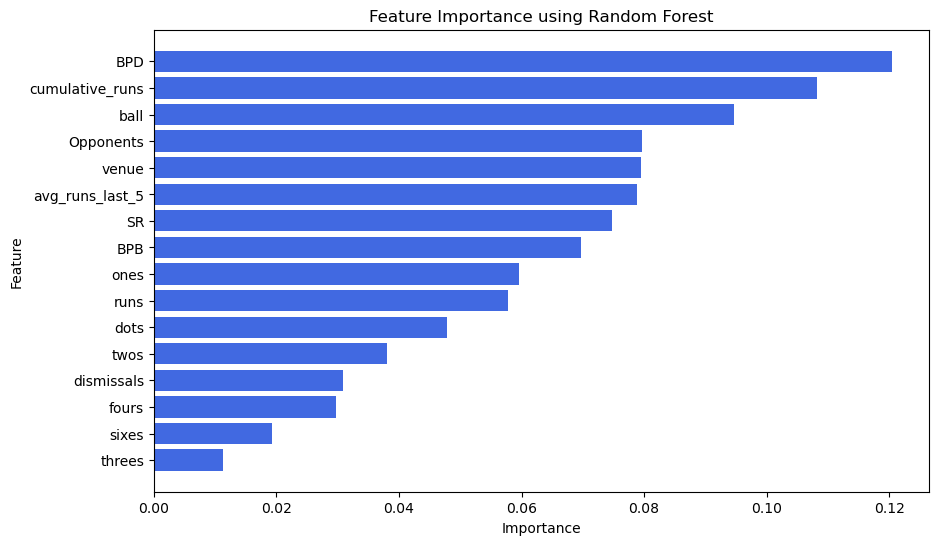

In [85]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Random Forest")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

### Random Forest Regressor

In [86]:
X = i_df[["BPD","cumulative_runs","ball","Opponents","venue","avg_runs_last_5","SR","BPB","ones","runs"]]

In [87]:
y = i_df["next_match_runs"]

In [89]:
from sklearn.model_selection import train_test_split

In [91]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
sc = StandardScaler

In [96]:
rfc = RandomForestRegressor(random_state=42)

In [97]:
rfc.fit(xtrain, ytrain)

RandomForestRegressor(random_state=42)

In [98]:
ypred = rfc.predict(xtest)

In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
mean_squared_error(ypred, ytest)

944.2713826086955

In [101]:
np.sqrt(mean_squared_error(ypred, ytest))

30.72899904989903

In [104]:
import xgboost as xgb

In [105]:
from sklearn.metrics import mean_squared_error, r2_score

In [106]:
i_df.head()

,runs,ball,dots,ones,twos,threes,fours,sixes,Opponents,venue,dismissals,SR,BPB,BPD,avg_runs_last_5,cumulative_runs,next_match_runs
0,7,7,3,3,0,0,1,0,0,16,1,100.000000,7.000000,7.0,27.636364,7,40.0
1,40,34,18,10,0,0,3,3,9,10,1,117.647059,5.666667,34.0,27.636364,40,6.0
2,6,7,5,0,1,0,1,0,4,18,1,85.714286,7.000000,7.0,27.636364,6,60.0
3,60,43,20,12,3,0,3,5,14,5,1,139.534884,5.375000,43.0,27.636364,60,31.0
4,31,26,11,9,2,0,3,1,5,10,1,119.230769,6.500000,26.0,28.800000,31,83.0


In [107]:
X = i_df.drop(["next_match_runs"],axis=1)
y = i_df["next_match_runs"]

In [108]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=42)

In [109]:
xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_regressor.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [111]:
ypred = xgb_regressor.predict(xtest)

In [112]:
mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

In [114]:
np.sqrt(mse)

34.060924840489726

In [115]:
r2

-0.4067830629800855

In [117]:
mse

1160.14660098949

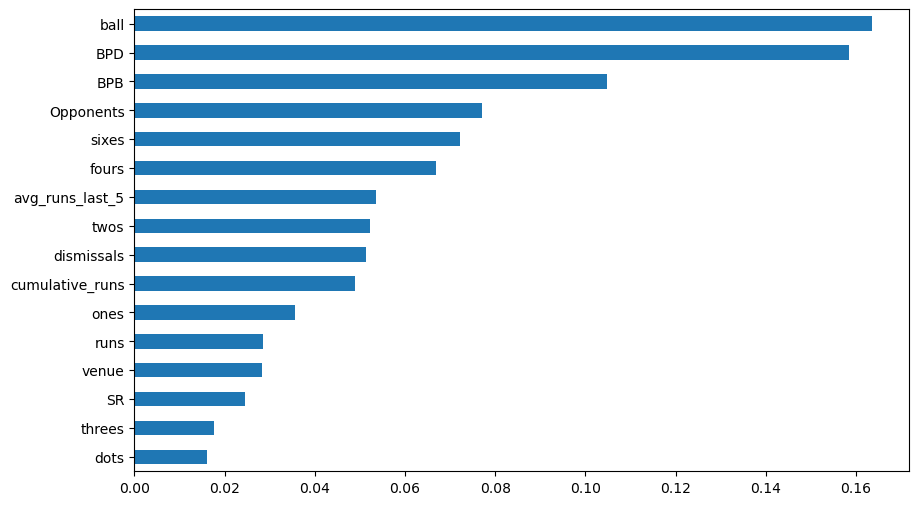

In [122]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Train XGBoost Model
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(xtrain, ytrain)  # Ensure X_train and y_train are correctly defined

# Now get feature importances
feature_importances = pd.Series(xgb.feature_importances_, index=xtrain.columns)

# Plot feature importance
feature_importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.show()


In [124]:
x = i_df[["ball","BPD","BPB","Opponents","sixes","fours","avg_runs_last_5"]]

In [125]:
y = i_df["next_match_runs"]

In [126]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2, random_state=42)

In [127]:
from sklearn.svm import SVR

In [128]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
svr = SVR(kernel='rbf', C=100, epsilon=0.1)

# Train models
rf.fit(xtrain, ytrain)
gbr.fit(xtrain, ytrain)
svr.fit(xtrain, ytrain)

# Predict
y_pred_rf = rf.predict(xtest)
y_pred_gbr = gbr.predict(xtest)
y_pred_svr = svr.predict(xtest)

# Evaluate
def evaluate_model(ytest, y_pred, model_name):
    mse = mean_squared_error(ytest, y_pred)
    r2 = r2_score(ytest, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:.4f}, R² Score: {r2:.4f}")

evaluate_model(ytest, y_pred_rf, "Random Forest")
evaluate_model(ytest, y_pred_gbr, "Gradient Boosting Regressor")
evaluate_model(ytest, y_pred_svr, "SVR")

Random Forest - Mean Squared Error: 937.8245, R² Score: -0.1372
Gradient Boosting Regressor - Mean Squared Error: 864.6958, R² Score: -0.0485
SVR - Mean Squared Error: 1202.7720, R² Score: -0.4585
